In [1]:
import pandas as pd
import scipy.io
import numpy as np
import scipy.sparse
import src.preprocessing.data_cleaning as data_cleaning
import src.preprocessing.normalization as normalization
import src.preprocessing.feature_selection as feature_selection
import src.preprocessing.dim_reduction as dim_reduction
import src.analysis.clustering as clustering
import src.analysis.cell_identification as cell_identification
import src.evaluation.evaluation as evaluation

def load_expression_data_from_mtx(path, n_sample=None, random_state=None):
    """
    Load gene expression data from MTX format into a sparse DataFrame.

    Parameters:
    - path: str, path to the folder with the matrix, genes and barcodes.

    Returns:
    - expression_matrix: Sparse DataFrame containing gene expression data.
    """
    # Load expression matrix
    matrix = scipy.io.mmread(path+"matrix.mtx").tocsc()

    # Load genes
    genes = pd.read_csv(path+"genes.tsv", header=None, sep='\t', names=['gene_id', 'gene_symbol'])

    # Load barcodes
    barcodes = pd.read_csv(path+"barcodes.tsv", header=None, sep='\t', names=['barcode'])

    # Apply random sampling to barcodes if n_sample is specified
    if n_sample is not None and n_sample < len(barcodes):
        np.random.seed(random_state)
        sampled_indices = np.random.choice(len(barcodes), size=n_sample, replace=False)
        matrix = matrix[:, sampled_indices]  # Subset columns (barcodes)
        barcodes = barcodes.iloc[sampled_indices]

    # Transform sparse matrix into pandas sparse DataFrame
    expression_matrix = pd.DataFrame.sparse.from_spmatrix(matrix)
    expression_matrix.index = genes['gene_symbol']
    expression_matrix.columns = barcodes['barcode']

    return expression_matrix

expression_matrix = load_expression_data_from_mtx("./data/PBMC/PBMC_68k/hg19/", n_sample=500, random_state=6)

print(expression_matrix.info())
print("Done")

c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'pandas.core.frame.DataFrame'>
Index: 32738 entries, MIR1302-10 to AC002321.1
Columns: 500 entries, CTCGAAGATTCCAT-1 to AATGCGTGTCCAAG-3
dtypes: Sparse[float64, 0](500)
memory usage: 307.9+ KB
None
Done


In [2]:
metadata_path = "./data/PBMC/PBMC_68k/hg19/68k_pbmc_barcodes_annotation.tsv"
true_labels = evaluation.load_true_labels(metadata_path, "barcodes", "celltype", "\t")
print(true_labels.info())
print(true_labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68579 entries, 0 to 68578
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   barcode     68579 non-null  object
 1   true_label  68579 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB
None
            barcode                    true_label
0  AAACATACACCCAA-1              CD8+ Cytotoxic T
1  AAACATACCCCTCA-1  CD8+/CD45RA+ Naive Cytotoxic
2  AAACATACCGGAGA-1           CD4+/CD45RO+ Memory
3  AAACATACTAACCG-1                       CD19+ B
4  AAACATACTCTTCA-1               CD4+/CD25 T Reg


In [3]:
duplicated_genes = expression_matrix.index[expression_matrix.index.duplicated()]
if len(duplicated_genes) > 0:
    print(f"Genes duplicados encontrados: {duplicated_genes}")

Genes duplicados encontrados: Index(['U1', 'EFNA3', 'DCAF8', 'MRPL30', 'LIMS3', 'KRBOX1', 'TLR9', 'RPP14',
       'CRYBG3', 'TM4SF19', 'UGT2A1', 'FAM47E-STBD1', 'CKS1B', 'CFB', 'TAP2',
       'SOGA3', 'AQP1', 'PSMA2', 'MRPS17', 'MUC3A', 'POLR2J2', 'IDS', 'SOX7',
       'DEFB130', 'OC90', 'ZFP41', '7SK', 'GALT', 'ANKRD18A', 'LCN6',
       'TMEM236', 'PI4K2A', 'GOLGA7B', 'NDUFB8', 'TIMM10B', 'PSMA1', 'KBTBD4',
       'ALG9', 'SDHD', 'MFRP', 'HOXC4', 'TMBIM4', 'SNORA40', 'LSP1', 'RNASE11',
       'TM9SF1', 'LTB4R2', 'KIAA0391', 'MDGA2', 'CCDC177', 'CRIP1', 'SNURF',
       'CELF6', 'ITFG3', 'NAA60', 'NPIPA7', 'NPIPA7', 'CLN3', 'PAGR1', 'SEPT1',
       'ZNF747', 'ZNF668', 'Y_RNA', 'CHTF8', '7SK', 'TUBB3', 'SHPK', 'CDRT1',
       'ZNF286A', 'Y_RNA', 'KRT222', 'ITGB3', 'ACE', 'SLC25A10', 'IER3IP1',
       'TMEM239', 'RBL1', 'UQCR11', 'NDUFA7', 'ZNF763', 'ZNF788', 'ZNF709',
       'PIK3R2', 'ZNF223', 'KLK9', 'SIGLEC5', 'ZNF8', '7SK', 'SLC5A3', 'FRG2C',
       'ZNF84', 'ZNF26', 'KIR3DL2', 'PNRC

In [4]:
from importlib import reload
reload(data_cleaning)
print("\tMatrix 1")
cleaned_matrix1 = data_cleaning.filter_lowly_expressed_genes(expression_matrix)
print(cleaned_matrix1.info())

print("\tMatrix 2")
cleaned_matrix2 = data_cleaning.filter_high_mitochondrial_content(expression_matrix)
print(cleaned_matrix2.info())

print("\tMatrix 3")
cleaned_matrix3 = data_cleaning.filter_doublets_cxds(expression_matrix)
print(cleaned_matrix3.info())

print("\tMatrix Combined")
cleaned_matrix_combined = data_cleaning.combined_cleaning(expression_matrix)
print(cleaned_matrix_combined.info())


	Matrix 1
<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, ISG15 to UQCR11
Columns: 500 entries, CTCGAAGATTCCAT-1 to AATGCGTGTCCAAG-3
dtypes: Sparse[float64, 0](500)
memory usage: 29.8+ KB
None
	Matrix 2
<class 'pandas.core.frame.DataFrame'>
Index: 32643 entries, MIR1302-10 to ZNF84
Data columns (total 90 columns):
 #   Column            Non-Null Count  Dtype             
---  ------            --------------  -----             
 0   TACTACACGGTGGA-3  32643 non-null  Sparse[float64, 0]
 1   CTACTCCTATTCGG-8  32643 non-null  Sparse[float64, 0]
 2   GATAGCACGTAGCT-1  32643 non-null  Sparse[float64, 0]
 3   GGAGACGAAAGTGA-8  32643 non-null  Sparse[float64, 0]
 4   CACATACTACTTTC-2  32643 non-null  Sparse[float64, 0]
 5   GAGTTGTGCCGTTC-7  32643 non-null  Sparse[float64, 0]
 6   TCACAACTACCTCC-4  32643 non-null  Sparse[float64, 0]
 7   GGCATATGACCCTC-1  32643 non-null  Sparse[float64, 0]
 8   CTGCAGCTGTCGAT-5  32643 non-null  Sparse[float64, 0]
 9   TAAGATTGGCAAGG-4  32643 non-nul

In [5]:
duplicated_genes = cleaned_matrix_combined.index[cleaned_matrix_combined.index.duplicated()]
if len(duplicated_genes) > 0:
    print(f"Genes duplicados encontrados: {duplicated_genes}")

In [6]:
reload(normalization)
print("\tMatrix 1")
norm_matrix1 = normalization.normalize_cpm(cleaned_matrix_combined)
print(norm_matrix1.info())

print("\tMatrix 2")
norm_matrix2 = normalization.normalize_quantile_regression(cleaned_matrix_combined)
print(norm_matrix2.info())

print("\tMatrix 3")
norm_matrix3 = normalization.normalize_negative_binomial(cleaned_matrix_combined)
print(norm_matrix3.info())


	Matrix 1
<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, ISG15 to UQCR11
Data columns (total 90 columns):
 #   Column            Non-Null Count  Dtype               
---  ------            --------------  -----               
 0   TACTACACGGTGGA-3  414 non-null    Sparse[float64, nan]
 1   CTACTCCTATTCGG-8  414 non-null    Sparse[float64, nan]
 2   GATAGCACGTAGCT-1  414 non-null    Sparse[float64, nan]
 3   GGAGACGAAAGTGA-8  414 non-null    Sparse[float64, nan]
 4   CACATACTACTTTC-2  414 non-null    Sparse[float64, nan]
 5   GAGTTGTGCCGTTC-7  414 non-null    Sparse[float64, nan]
 6   TCACAACTACCTCC-4  414 non-null    Sparse[float64, nan]
 7   GGCATATGACCCTC-1  414 non-null    Sparse[float64, nan]
 8   CTGCAGCTGTCGAT-5  414 non-null    Sparse[float64, nan]
 9   TAAGATTGGCAAGG-4  414 non-null    Sparse[float64, nan]
 10  TTGAATGATTGTGG-3  414 non-null    Sparse[float64, nan]
 11  ATAGAACTCTTATC-5  414 non-null    Sparse[float64, nan]
 12  GGAGGCCTCTCTCG-1  414 non-null    Spar

In [7]:
# Feature selection
reload(feature_selection)
print("\tMatrix 1")
selected_matrix1 = feature_selection.select_highly_variable_genes(norm_matrix3)
print(selected_matrix1.info())

print("\tMatrix 2")
selected_matrix2 = feature_selection.select_genes_by_variance(norm_matrix3)
print(selected_matrix2.info())

	Matrix 1
<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, MALAT1 to CRIP1
Data columns (total 90 columns):
 #   Column            Non-Null Count  Dtype             
---  ------            --------------  -----             
 0   TACTACACGGTGGA-3  414 non-null    Sparse[float64, 0]
 1   CTACTCCTATTCGG-8  414 non-null    Sparse[float64, 0]
 2   GATAGCACGTAGCT-1  414 non-null    Sparse[float64, 0]
 3   GGAGACGAAAGTGA-8  414 non-null    Sparse[float64, 0]
 4   CACATACTACTTTC-2  414 non-null    Sparse[float64, 0]
 5   GAGTTGTGCCGTTC-7  414 non-null    Sparse[float64, 0]
 6   TCACAACTACCTCC-4  414 non-null    Sparse[float64, 0]
 7   GGCATATGACCCTC-1  414 non-null    Sparse[float64, 0]
 8   CTGCAGCTGTCGAT-5  414 non-null    Sparse[float64, 0]
 9   TAAGATTGGCAAGG-4  414 non-null    Sparse[float64, 0]
 10  TTGAATGATTGTGG-3  414 non-null    Sparse[float64, 0]
 11  ATAGAACTCTTATC-5  414 non-null    Sparse[float64, 0]
 12  GGAGGCCTCTCTCG-1  414 non-null    Sparse[float64, 0]
 13  CCTCATCT

In [32]:
# Dim reduction
reload(dim_reduction)
print("\tPCA")
pca_object, pca_matrix = dim_reduction.apply_pca(selected_matrix1)
print(pca_matrix.info())
print(pca_object)
print(pca_matrix.shape[1])

print("\tUMAP")
umap_matrix = dim_reduction.apply_umap(selected_matrix1, pca_matrix.shape[1])
print(umap_matrix.info())

print("\tt-SNE")
tsne_matrix = dim_reduction.apply_tsne(selected_matrix1, 2)
print(tsne_matrix.info())

	PCA
<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, TACTACACGGTGGA-3 to AATGCGTGTCCAAG-3
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC_1    90 non-null     float64
 1   PC_2    90 non-null     float64
 2   PC_3    90 non-null     float64
 3   PC_4    90 non-null     float64
 4   PC_5    90 non-null     float64
 5   PC_6    90 non-null     float64
 6   PC_7    90 non-null     float64
 7   PC_8    90 non-null     float64
 8   PC_9    90 non-null     float64
dtypes: float64(9)
memory usage: 9.1+ KB
None
PCA()
9
	UMAP
<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, TACTACACGGTGGA-3 to AATGCGTGTCCAAG-3
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UMAP_1  90 non-null     float32
 1   UMAP_2  90 non-null     float32
 2   UMAP_3  90 non-null     float32
 3   UMAP_4  90 non-null     float32
 4   UMAP_5  90 non-null     float32
 5   UMAP_6  90 n

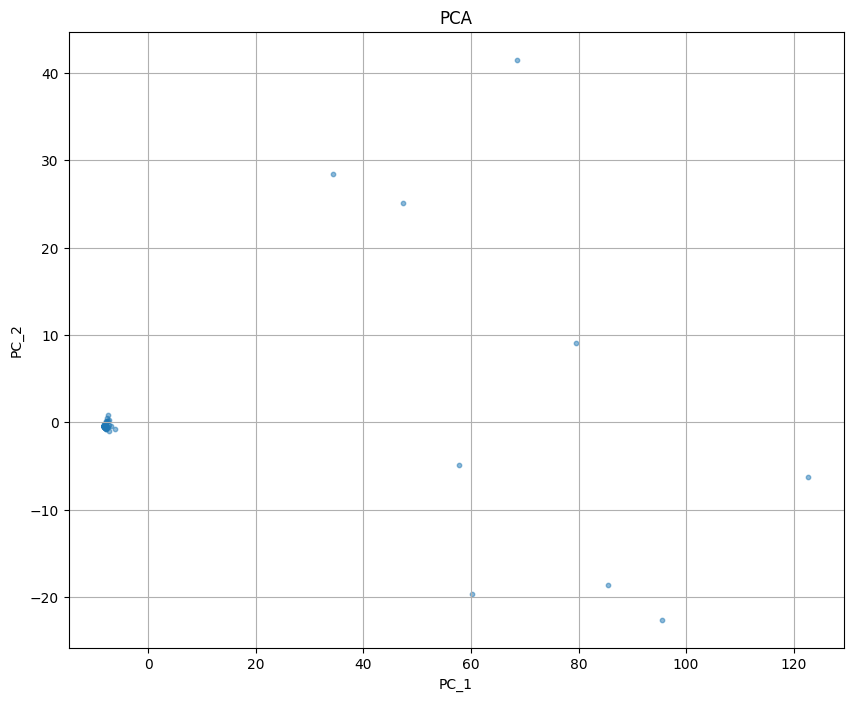

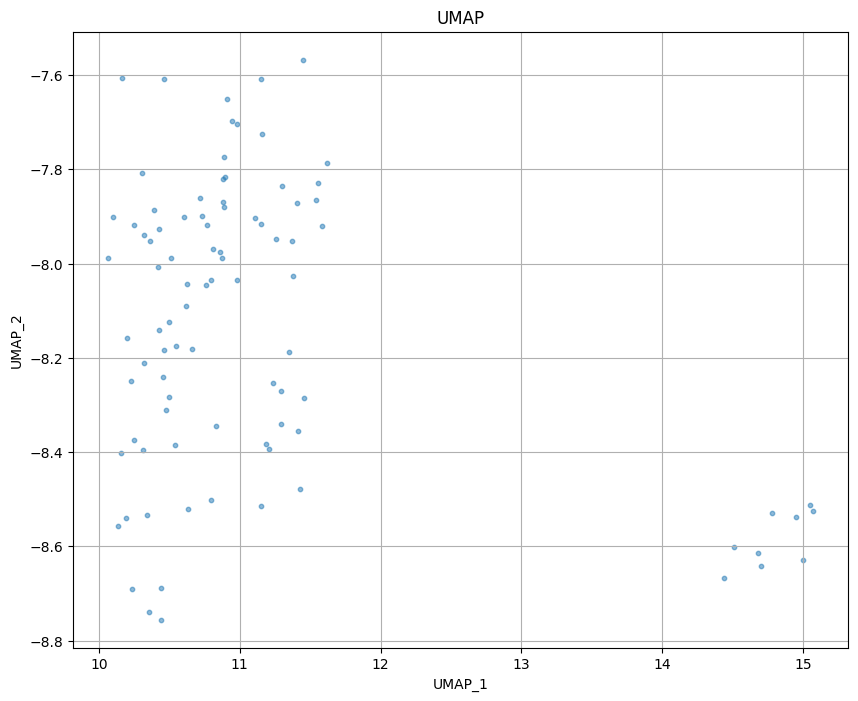

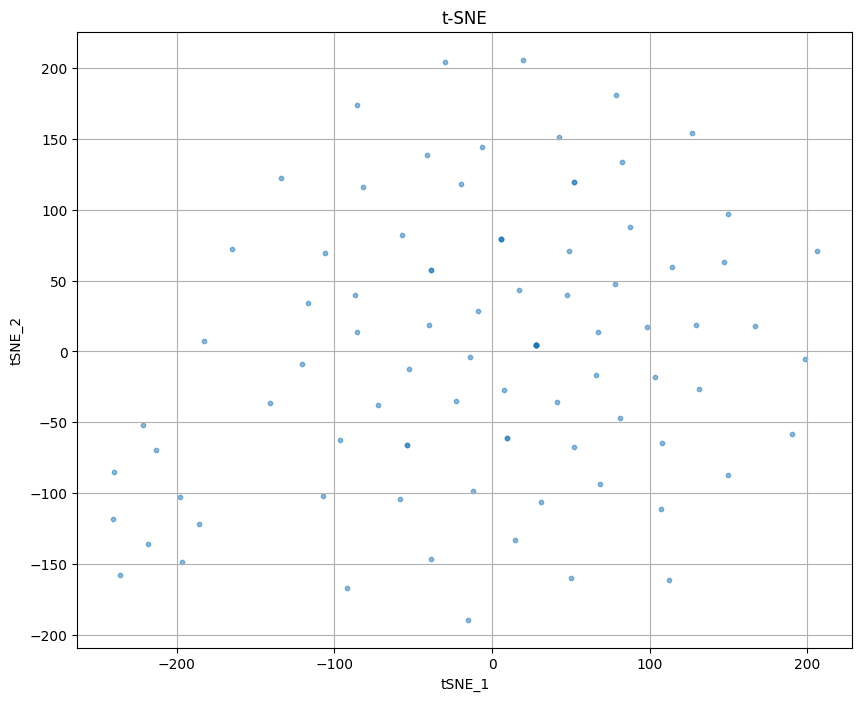

In [33]:
# Visualization
reload(dim_reduction)
# elbow plot
dim_reduction.elbow_plot(pca_object)
# visualization
dim_reduction.visualize_dim_reduction(pca_matrix.iloc[:, :2], 'PCA')
dim_reduction.visualize_dim_reduction(umap_matrix.iloc[:, :2], 'UMAP')
dim_reduction.visualize_dim_reduction(tsne_matrix.iloc[:, :2], 't-SNE')


In [53]:
# Clustering
reload(clustering)
print("\tGraph based")
clustering1 = clustering.graph_based_clustering_leiden(tsne_matrix)
print(clustering1.head())

print("\tDensity based")
clustering2 = clustering.density_based_clustering(tsne_matrix)
print(clustering2.head())

print("\tDistance based")
clustering3 = clustering.distance_based_clustering(tsne_matrix)
print(clustering3.head())

print("\tHierarchical")
clustering4 = clustering.hierarchical_clustering(tsne_matrix)
print(clustering4.head())

print("\tDeep Learning")
clustering5 = clustering.deep_learning_clustering(tsne_matrix)
print(clustering5.head())

print("\tAffinity propagation")
clustering6 = clustering.affinity_propagation_clustering(tsne_matrix)
print(clustering6.head())

print("\tMixture model")
clustering7 = clustering.mixture_model_clustering(tsne_matrix, n_components=pca_matrix.shape[1])
print(clustering7.head())

print("\tEnsemble")
clustering8 = clustering.ensemble_clustering(tsne_matrix, n_clusters=10, n_components=pca_matrix.shape[1])
print(clustering8.head())


	Graph based
barcode
TACTACACGGTGGA-3    3
CTACTCCTATTCGG-8    0
GATAGCACGTAGCT-1    2
GGAGACGAAAGTGA-8    2
CACATACTACTTTC-2    1
dtype: int32
	Density based
barcode
TACTACACGGTGGA-3   -1
CTACTCCTATTCGG-8   -1
GATAGCACGTAGCT-1   -1
GGAGACGAAAGTGA-8   -1
CACATACTACTTTC-2   -1
dtype: int64
	Distance based
barcode
TACTACACGGTGGA-3    6
CTACTCCTATTCGG-8    9
GATAGCACGTAGCT-1    6
GGAGACGAAAGTGA-8    9
CACATACTACTTTC-2    1
dtype: int32
	Hierarchical
barcode
TACTACACGGTGGA-3    3
CTACTCCTATTCGG-8    2
GATAGCACGTAGCT-1    3
GGAGACGAAAGTGA-8    8
CACATACTACTTTC-2    4
dtype: int64
	Deep Learning
Epoch 1/50
1/1 [==============================] - 0s 389ms/step - loss: 10312.8711
Epoch 2/50
1/1 [==============================] - 0s 4ms/step - loss: 10312.1826
Epoch 3/50
1/1 [==============================] - 0s 5ms/step - loss: 10311.9258
Epoch 4/50
1/1 [==============================] - 0s 677us/step - loss: 10311.7969
Epoch 5/50
1/1 [==============================] - 0s 15ms/step - loss: 1031

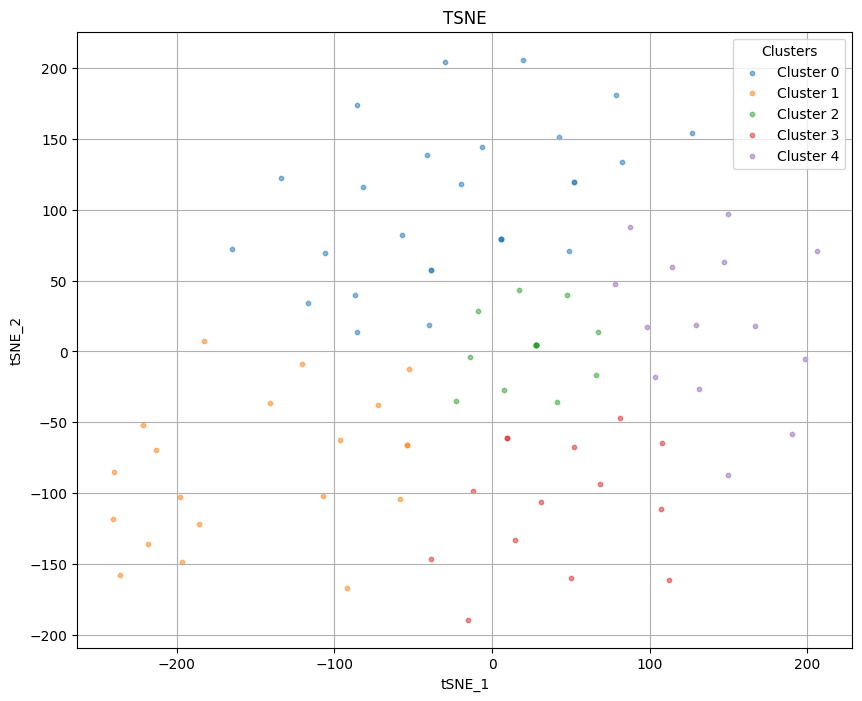

In [56]:
# Clustering visualization
reload(clustering)
clustering.visualize_clusters(tsne_matrix, 'TSNE', clustering1)

In [90]:
# Cell identification
reload(cell_identification)
expression_matrix = data_cleaning.remove_duplicated_genes(expression_matrix)
print("\tExpression profile")
expression_profile = cell_identification.generate_expression_profiles(expression_matrix, metadata_path, celltype_column='celltype', sep='\t')
print(expression_profile.info())
print(expression_profile.head())

print("\tMarker reference")
marker_genes = cell_identification.generate_marker_reference(expression_matrix, metadata_path, celltype_column='celltype', sep='\t')
print(list(marker_genes.items())[:5])

print("\tReference based")
cell_id_1 = cell_identification.reference_based_assignment(selected_matrix1, clustering1, expression_profile)
print(cell_id_1.head(10))

print("\tCorrelation based")
cell_id_2 = cell_identification.correlation_based_assignment(selected_matrix1, clustering1, expression_profile)
print(cell_id_2.head())

print("\tMarker based")
cell_id_3 = cell_identification.marker_based_assignment(selected_matrix1, clustering1, marker_genes)
print(cell_id_3.head())

	Expression profile
<class 'pandas.core.frame.DataFrame'>
Index: 32643 entries, MIR1302-10 to ZNF84
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CD56+ NK                      32643 non-null  float64
 1   CD8+ Cytotoxic T              32643 non-null  float64
 2   CD8+/CD45RA+ Naive Cytotoxic  32643 non-null  float64
dtypes: float64(3)
memory usage: 1020.1+ KB
None
celltype      CD56+ NK  CD8+ Cytotoxic T  CD8+/CD45RA+ Naive Cytotoxic
gene_symbol                                                           
MIR1302-10         0.0               0.0                           0.0
FAM138A            0.0               0.0                           0.0
OR4F5              0.0               0.0                           0.0
RP11-34P13.7       0.0               0.0                           0.0
RP11-34P13.8       0.0               0.0                           0.0
	Marker reference
[('CD56+ 

TypeError: correlation_based_assignment() takes 2 positional arguments but 3 were given

In [61]:
# Evaluation metrics


In [ ]:
# Save results


In [ ]:
import pandas as pd
import scipy.sparse
import joblib

# Ruta al archivo CSV
csv_path = "../data/Neuronal/M1/matrix.csv"

def read_and_process_csv_in_chunks(csv_path, chunk_size=10000, output_file='../data/Neuronal/M1/sparse_dataframe.joblib'):
    """
    Read a large CSV file in chunks, transpose, convert to sparse, and concatenate.

    Parameters:
    - csv_path: str, path to the CSV file.
    - chunk_size: int, number of rows to read in each chunk.

    Returns:
    - sparse_expression_matrix: Sparse DataFrame containing the full gene expression data.
    """
    # Initialize a list to store processed chunks
    processed_chunks = []
    genes = None
    barcodes = []
    print(f"Empezamos", flush=True)
    
    # Read the CSV in chunks
    for chunk in pd.read_csv(csv_path, sep=',', chunksize=chunk_size,  header=0, index_col=0):
        print(f"Processing chunk rows {chunk.index[0]} to {chunk.index[-1]}...", flush=True)

        # Keep genes
        if genes is None:
            genes = chunk.columns.tolist()
        
        # Keep barcodes
        barcodes.extend(chunk.index.tolist())
        
        # Transpose the chunk so rows are genes and columns are barcodes
        chunk = chunk.T
        
        # Convert to Sparse DataFrame
        sparse_chunk = scipy.sparse.csr_matrix(chunk)
        
        # Add the processed chunk to the list
        processed_chunks.append(sparse_chunk)
        
        # Free memory from the current chunk
        del chunk  # Optional, to ensure the original chunk memory is freed
        
    # Concatenate all processed chunks into a single Sparse DataFrame
    full_sparse_matrix = scipy.sparse.vstack(processed_chunks)
    sparse_expression_matrix = pd.DataFrame.sparse.from_spmatrix(
        full_sparse_matrix,
        index=genes,
        columns=barcodes
    )

    joblib.dump(sparse_expression_matrix, output_file)
    
    # Return the complete Sparse DataFrame
    return sparse_expression_matrix

def load_sparse_dataframe(input_file='../data/Neuronal/M1/sparse_dataframe.joblib'):
    return joblib.load(input_file)


# Read and process the CSV in chunks
sparse_matrix = read_and_process_csv_in_chunks(csv_path)

sparse_dataframe = load_sparse_dataframe('../data/Neuronal/M1/sparse_dataframe.joblib')

# Show column names (First 10)
print("Column Names Matrix (First 10):", sparse_matrix.columns[:10])

# Show head of the Sparse Expression Matrix
print("\nHead of the Sparse Expression Matrix:")
print(sparse_matrix.head())

# Show data types of the Sparse Expression Matrix
print("\nData Types of the Sparse Expression Matrix:")
print(sparse_matrix.dtypes)

# Show shape of the Sparse Expression Matrix
print("\nShape of the Sparse Expression Matrix:", sparse_matrix.shape)

# Mostrar información
print("Dimensiones de la matriz:", sparse_dataframe.shape)
print("\nPrimeros 5 genes:", sparse_dataframe.index[:5])
print("\nPrimeros 5 barcodes:", sparse_dataframe.columns[:5])
print("\nMuestra de la matriz:")
print(sparse_dataframe.iloc[:5, :5])

Empezamos
Processing chunk rows AAACCCAAGGATTTCC-LKTX_190129_01_A01 to ATCGCCTTCACTGGGC-LKTX_190129_01_C01...
Processing chunk rows ATCGCCTTCGAGAAAT-LKTX_190129_01_C01 to CATCCACAGGCCGCTT-LKTX_190129_01_E01...
Processing chunk rows CATCCACCAAATGCGG-LKTX_190129_01_E01 to TTTCGATCACCATTCC-LKTX_190129_01_F01...
Processing chunk rows TTTCGATCATACATCG-LKTX_190129_01_F01 to TCGCTTGGTTTACGTG-LKTX_190130_01_A01...
